In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from subprocess import check_output
import glob
import cv2 as cv
import multiprocessing as mp
from itertools import repeat
%matplotlib inline

In [2]:
base_path = "/home/nbatanay/.kaggle/diabetic_retinopathy_detection/train_preprocessed/"
images_files = glob.glob(base_path+"images_*.pkl")
label_ids_files = glob.glob(base_path+"lab_id_*.pkl")

### Load 1 batch of data, 2000 images

In [3]:
%%time
num_batch = 1
images = []
label_ids = []
for img_file in np.sort(images_files)[:num_batch]: 
    img = pd.read_pickle(img_file)
    batch = img_file.split("_")[-1].split(".")[0]
    lab_id_file = base_path+"lab_id_%s.pkl"%batch
    lab_id = pd.read_pickle(lab_id_file)
    
    images.append(img)
    label_ids.append(lab_id)
    
images = np.concatenate(images)
label_ids = np.concatenate(label_ids)

CPU times: user 11.4 s, sys: 36.4 s, total: 47.8 s
Wall time: 1min 26s


In [4]:
images.shape, label_ids.shape

((2000, 700, 700, 3), (2000, 2))

### Show some examples

In [5]:
num_to_pick = 5 #per row per class label
idx = np.array([np.random.choice(np.where(label_ids[:, 1]==i)[0], num_to_pick, replace=False) \
       for i in np.sort(np.unique(label_ids[:, 1]))]).flatten()
images_rpick = images[idx]
label_ids_rpick = label_ids[idx]

In [6]:
def plotter(images, labels):
    num_plots = len(images)
    num_cols = 5
    num_rows = num_plots//num_cols if num_plots%num_cols==0 else (num_plots//num_cols)+1
    
    fig, ax = plt.subplots(figsize=(20,num_rows*4), nrows=num_rows, ncols=num_cols)
    ax = ax.flatten()
    for i in range(len(images)):
        ax[i].imshow(images[i])
        ax[i].set_title("Participant: %s | Label: %s"%(labels[i][0], labels[i][1]))
    

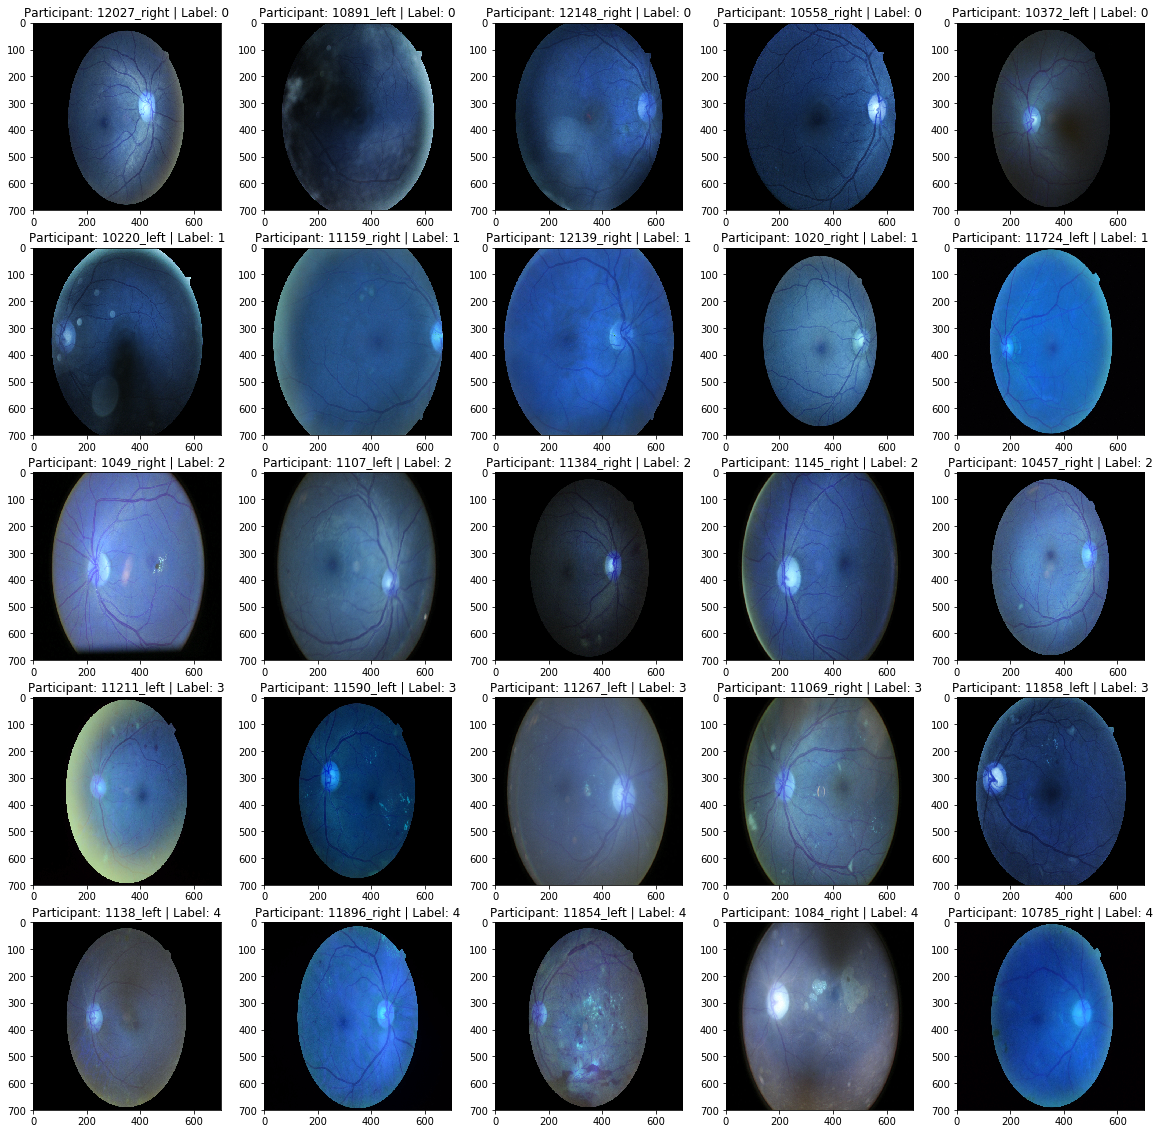

In [7]:
plotter(images_rpick, label_ids_rpick)

In [8]:
%%time
def dist_class(lab_id_file):
    label_ids = pd.read_pickle(lab_id_file)
    dist = pd.value_counts(label_ids[:, 1])
    return dist

pool = mp.Pool(processes=mp.cpu_count())
dist_batch = pd.concat(pool.map(dist_class,\
                label_ids_files), axis=1, sort=True)

CPU times: user 0 ns, sys: 4.13 s, total: 4.13 s
Wall time: 4.57 s


In [9]:
dist_batch

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1512,1491,1486,1440,1430,1454,1439,1503,1412,1473,796,1455,1485,1467,1493,1466,1495,1513
1,119,154,132,141,137,149,170,138,152,118,91,123,133,139,151,142,129,125
2,294,276,291,318,348,305,328,274,328,308,189,305,286,310,288,295,289,260
3,46,48,42,64,38,57,37,50,63,59,20,70,42,45,40,54,43,55
4,29,31,49,37,47,35,26,35,45,42,30,47,54,39,28,43,44,47


In [10]:
#distribution of class labels
dist_batch.sum(axis=1)/dist_batch.values.sum()

0    0.734783
1    0.069550
2    0.150658
3    0.024853
4    0.020156
dtype: float64

### Deeplearning 

In [11]:
#check if GPU is properly configured
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

/home/nbatanay/.conda/envs/diab_ret/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2175742024633045019, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7960150016
 locality {
   bus_id: 2
 }
 incarnation: 17840878176273115671
 physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:81:00.0, compute capability: 6.1"]